In [15]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy

# Convert heic files to jpg files

In [16]:
# import glob
# # Register the HEIF plugin
# import pillow_heif
# pillow_heif.register_heif_opener()

# # Convert files with baby
# file_names=glob.glob(r'C:\Users\gregoryd\Documents\Ben\OpenCV\LuciaIdentifier\Pictures\Train\Baby\*.heic')
# for name in file_names:
#     # Import image 
#     image=Image.open(name)
#     # All heifs aren't always in RGB. Convert to RGB.
#     image = image.convert("RGB")
#     image.save(f"{name[:-5]}.jpg", "JPEG")

# # Convert files wihtout baby
# file_names=glob.glob(r'C:\Users\gregoryd\Documents\Ben\OpenCV\LuciaIdentifier\Pictures\Train\NoBaby\*.heic')
# for name in file_names:
#     # Import image 
#     image=Image.open(name)
#     # All heifs aren't always in RGB. Convert to RGB.
#     image = image.convert("RGB")
#     image.save(f"{name[:-5]}.jpg", "JPEG")

# PreProcessing

In [26]:
# Directory to folders of images
# This directory contrains two folders, one called "Baby" and one called "NoBaby"
# We aren't doing seperate folders for train, test, and validation. We will split later.
directory=r'C:\Users\gregoryd\Documents\Ben\OpenCV\LuciaIdentifier\Pictures\Train'

# Create generator
data=tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=['NoBaby','Baby'], # First folder is class 0, second folder is class 1
    color_mode='rgb',
    batch_size=20, # default 32
    image_size=(256, 256),
    shuffle=True,
    seed=1,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 618 files belonging to 2 classes.


In [27]:
# # Create iterator from generator
# data_iterator=data.as_numpy_iterator()

# # Get one batch from the iterator
# batch=data_iterator.next()
# # Images
# print(batch[0].shape)
# # Labels
# print(batch[1].shape)

# # This plot checks which label is with which image by plotting a few images
# # Class 1 = baby
# # Class 0 = no baby
# fig,ax=plt.subplots(ncols=2,figsize=(10,4))
# for idx,img in enumerate(batch[0][0:2]):
#     ax[idx].imshow(img.astype(int))
#     ax[idx].set_title(batch[1][idx])

In [31]:
# Scale data to between 0 and 1
# map applies lambda function "in pipeline"
# x is the first element of our batch, or the images. y is the labels
data_scaled=data.map(lambda x,y: (x/255,y))

In [32]:
# Check the scaled data
print(data_scaled.as_numpy_iterator().next()[0].max())
print(data_scaled.as_numpy_iterator().next()[0].min())

1.0
0.0


# Split

In [33]:
# Manual "guess and check" process to divide batches into train, val, and test set
# This code is just selecting how many batches in each set
# Actual splitting happens in next cell

print(len(data_scaled)) # number of batches of data we have

train_size=int(len(data_scaled)*0.7) # 70% for train
val_size=int(len(data_scaled)*0.2) # 20% for validation
test_size=int(len(data_scaled)*0.1)+1 # 10% for test

print(train_size)
print(val_size)
print(test_size)
print(train_size+test_size+val_size)

31
21
6
4
31


In [34]:
# Set aside batches for train, validation, and test
# Data must be shuffled prior to doing this

train=data_scaled.take(train_size)
val=data_scaled.skip(train_size).take(val_size)
test=data_scaled.skip(train_size+val_size).take(test_size)

# Model

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

### Model Architecture

In [38]:
# This is a farily simple model. We will build sequentially.
model = Sequential()

In [39]:
# 16 filters in convulution
# each filter is of size 3x3 pixels
# stride of 1
model.add(Conv2D(16,(3,3),1,activation='relu',input_shape=(256,256,3)))
# Condenses information
# Default is 2x2 region. So takes max value out of 2x2 region
# Halves the data
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [58]:
model.compile('adam',loss=tf.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

### Model Training

In [56]:
hist = model.fit(train,epochs=20,validation_data=val)

Epoch 1/20


 1/21 [>.............................] - ETA: 2:01 - loss: 0.0109 - accuracy: 1.0000

KeyboardInterrupt: 

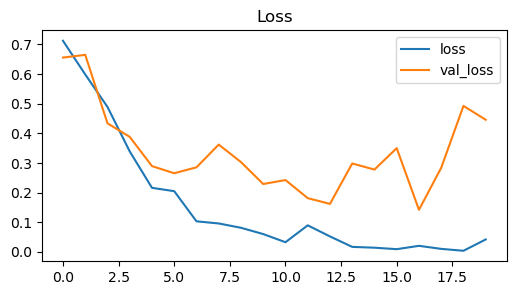

In [59]:
# Plot loss function for train and validation set

plt.figure(figsize=(6,3))
plt.plot(hist.history['loss'],label='loss')
plt.plot(hist.history['val_loss'],label='val_loss')
plt.title('Loss')
plt.legend()

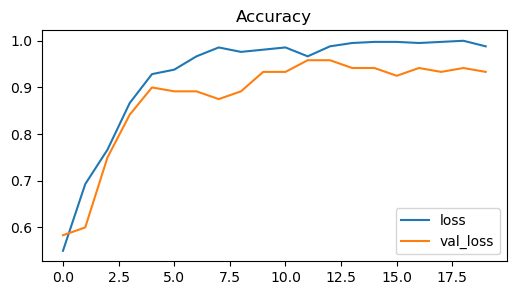

In [60]:
# Plot accuracy of train and validation set

plt.figure(figsize=(6,3))
plt.plot(hist.history['accuracy'],label='loss')
plt.plot(hist.history['val_accuracy'],label='val_loss')
plt.title('Accuracy')
plt.legend()

### Model Evaluation

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
precision=Precision()
recall=Recall()
accuracy=BinaryAccuracy()

In [67]:
# Find model percision and recall
for batch in test.as_numpy_iterator():
    X,y=batch
    y_pred=model.predict(X)
    precision.update_state(y,y_pred)
    recall.update_state(y,y_pred)
    accuracy.update_state(y,y_pred)

1/1 [==============================] - 0s 221ms/step


In [70]:
print(precision.result().numpy())
print(recall.result().numpy())
print(accuracy.result().numpy())

0.81632656
1.0
0.88461536
